# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    img = plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.colorbar(img)
    plt.show()

def niceDisplay14(affichages,titres=None):
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray")
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

    
#tme 4 convolution function
def imagePad(I,h):
    shape = np.array(I).shape
    add = int((h.shape[0] - 1)/2)
    newImage = np.zeros((add*2 + shape[0],add*2 + shape[1]))
    newImage[add:-add, add:-add] = I
    return newImage

def conv2(I,h):
    shape = np.array(I).shape
    img = np.zeros(shape)
    imPad = imagePad(I,h)
    for x in range(shape[0]):
        for y in range(shape[1]):
            selectedNeigbourg = imPad[x:x+h.shape[0],y:y+h.shape[1]] 
            img[x][y] = (selectedNeigbourg * h).sum()
    
    return img

def treshold(I, t):
    return np.where(I < t,0,255)

#I added a factor parameter for easier sub sampling
def subSample(I, factor=2):
    """ Array -> Array """
    return I[::factor,::factor]

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    Ix = convolve2d(I, Sx)
    Iy = convolve2d(I, Sy)
    
    G = np.sqrt(np.power(Ix,2) + np.power(Iy,2))
    return np.where(G > s, 1, 0)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    
    imgFil = imagePad(convolve2d(I, L),L)
    img = np.zeros(I.shape)    
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            sn = imgFil[x:x+L.shape[0],y:y+L.shape[0]]
            snMax = np.max(sn)
            snMin = np.min(sn)
            if(snMax > 0 and snMin < 0 and (snMax - snMin) > s):
                img[x][y] = 1
    
    return img

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

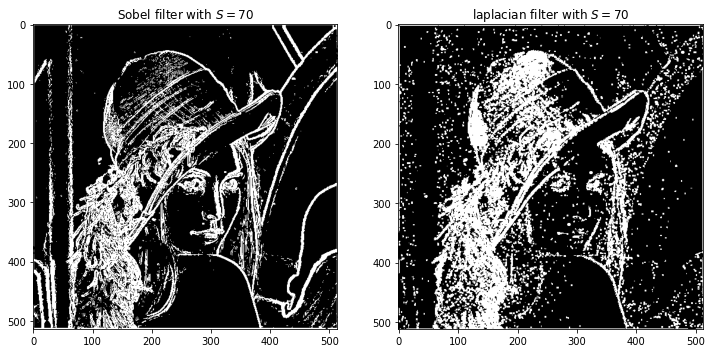

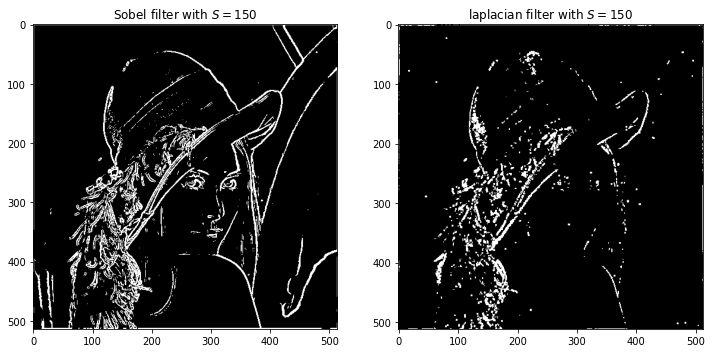

In [4]:
I = np.array(Image.open("img/lena.png"))

niceDisplay14([SobelDetector(I,70),LaplacianDetector(I,70)],["Sobel filter with $S=70$","laplacian filter with $S=70$"])
niceDisplay14([SobelDetector(I,150),LaplacianDetector(I,150)],["Sobel filter with $S=150$","laplacian filter with $S=150$"])

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


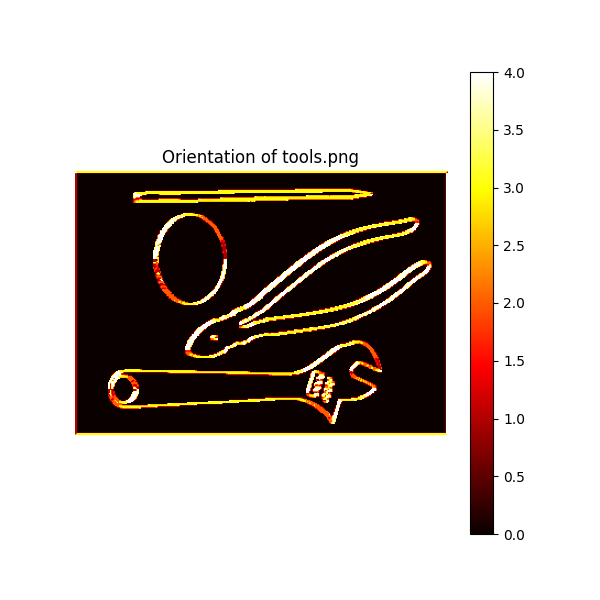

In [5]:
%matplotlib notebook
#### your answer below

img = Image.open("img/tools.png")

#same as the soble filter but without the edge threshold
def sobleTuple(I):
    Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

    Ix = convolve2d(I, Sx)
    Iy = convolve2d(I, Sy)

    Ig = np.sqrt(np.power(Ix,2) + np.power(Iy,2))
    
    return Ix, Iy, Ig

Imax,Imay,Imag = sobleTuple(img)
ort = orientation(Imax,Imay,Imag)

imshow_hot(ort, "Orientation of tools.png")

Explain the different values given to a pixel by `orientation()`:

there is 5 value possible : $0,\frac{1\pi}4,\frac{2\pi}4,\frac{3\pi}4,\frac{4\pi}4$ 

with the color bar we can see wich value is attribute to wich color.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [164]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    
    edge = np.zeros(Ig.shape)
    pad = imagePad(Ig, np.zeros((3,3)))
    
    for x in range(1,Ig.shape[0]): 
        for y in range(1,Ig.shape[1]): 
            A = float('inf')
            B = float('inf')
            
            orientation = Ior[x-1,y-1]
            
            #since we have padded everything we need to check 
            if orientation == 1:
                A = pad[x, y-1]
                B = pad[x, y+1]
            if orientation == 2:
                A = pad[x-1,y+1]
                B = pad[x+1,y-1]
            if orientation == 3:
                A = pad[x-1,y]
                B = pad[x+1,y]
            if orientation == 4:
                A = pad[x-1,y-1]
                B = pad[x+1,y+1]
            
            if max(Ig[x-1,y-1],A,B) == Ig[x-1,y-1]:
                edge[x-1,y-1] = Ig[x-1,y-1]
    
    return edge

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


In [165]:
%matplotlib inline
def performNMS(img):
    Imax,Imay,Imag = sobleTuple(img)
    ort = orientation(Imax,Imay,Imag)
    return nms(Imag,ort)

print(gaussianKernel(7).sum())

306.57710425958976


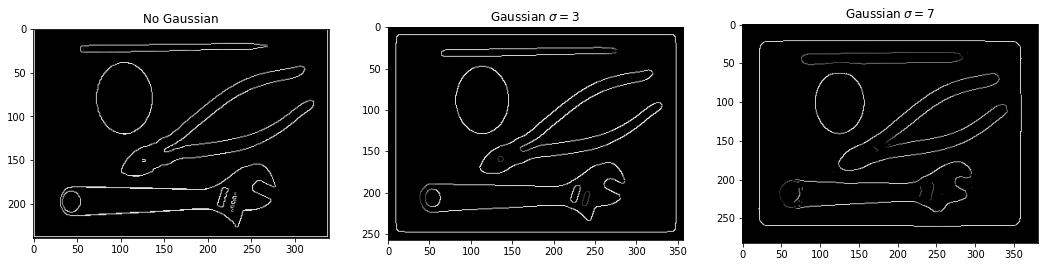

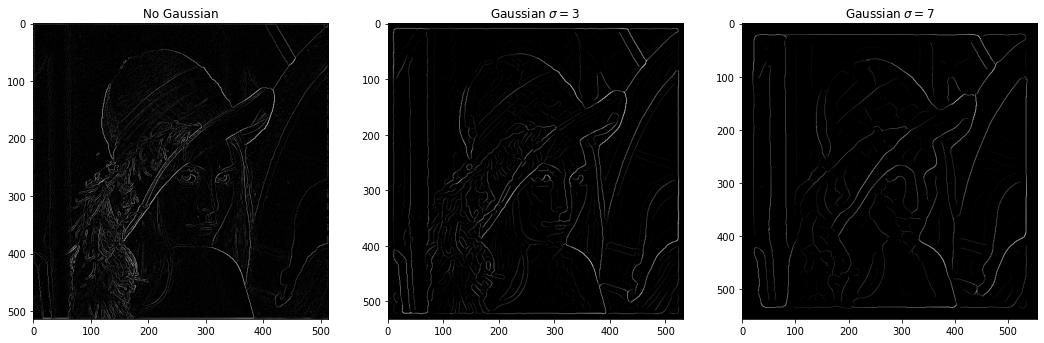

In [166]:
img = Image.open("img/tools.png")
toolNoGaussian = performNMS(img)
toolGaussian3 = performNMS(convolve2d(img,gaussianKernel(3)))
toolGaussian7 = performNMS(convolve2d(img,gaussianKernel(7)))

img = Image.open("img/lena.png")
lenaNoGaussian = performNMS(img)
lenaGaussian3 = performNMS(convolve2d(img,gaussianKernel(3)))
lenaGaussian7 = performNMS(convolve2d(img,gaussianKernel(7)))

niceDisplay14([toolNoGaussian,toolGaussian3,toolGaussian7],["No Gaussian", "Gaussian $\sigma=3$", "Gaussian $\sigma=7$"])
niceDisplay14([lenaNoGaussian,lenaGaussian3,lenaGaussian7],["No Gaussian", "Gaussian $\sigma=3$", "Gaussian $\sigma=7$"])


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

with no $\sigma$, we can see in the two picture (but more on Lena) that noisy area affect the contouring.

But with a $\sigma$ we see that the high frequency area are less detected (than normal since a gaussian filter is a low-pass filter), the higher the $\sigma$ is the less noisy the area get but the edge are not that good. 

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

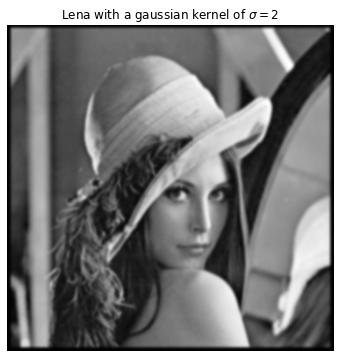

In [10]:
img = Image.open("img/lena.png")
lenaGauss2 = convolve2d(img,gaussianKernel(2))
imshow(lenaGauss2, "Lena with a gaussian kernel of $\sigma=2$")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

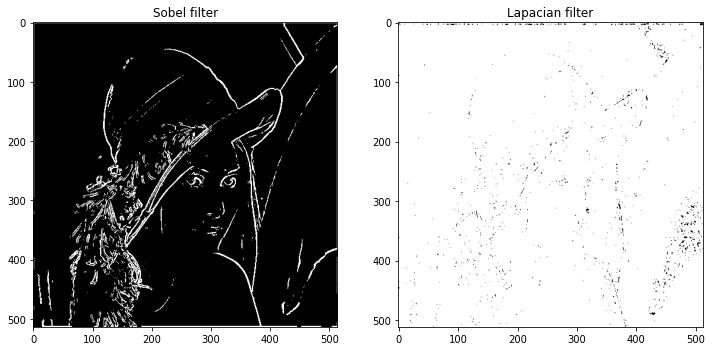

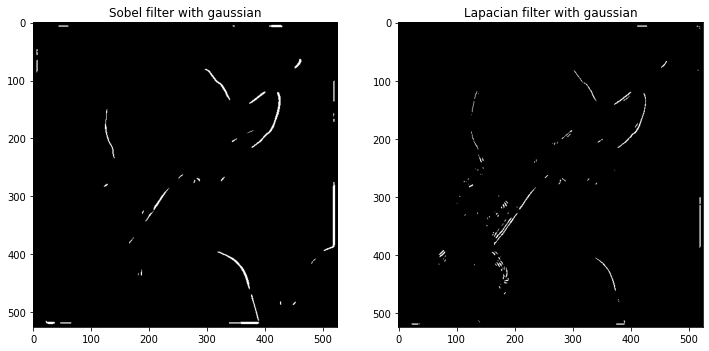

In [6]:
Sob = SobelDetector(np.array(img),200)
Lap = LaplacianDetector(np.array(img),10)

niceDisplay14([Sob,Lap],["Sobel filter","Lapacian filter"])

Sob2 = SobelDetector(lenaGauss2,200)
Lap2 = LaplacianDetector(lenaGauss2,15)

niceDisplay14([Sob2,Lap2],["Sobel filter with gaussian","Lapacian filter with gaussian"])

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

the sobel filter seem less sensitive to the gaussian filter than the Lapacian. and as say in the upper text smoothing the noise make the edge detection pick up less the high frequency.


### the solution underneath seem really wrong but could figure why

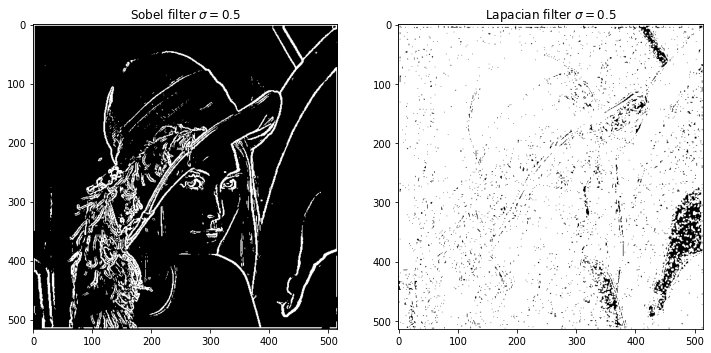

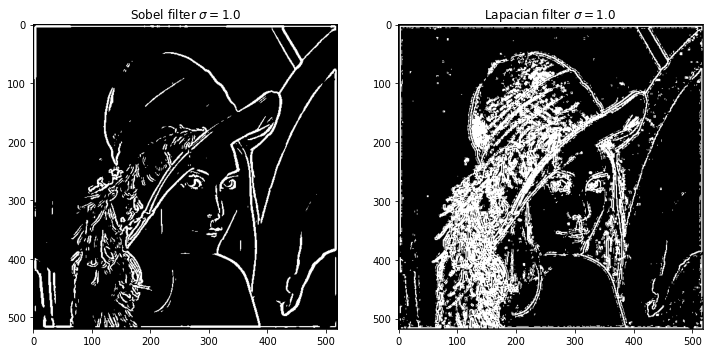

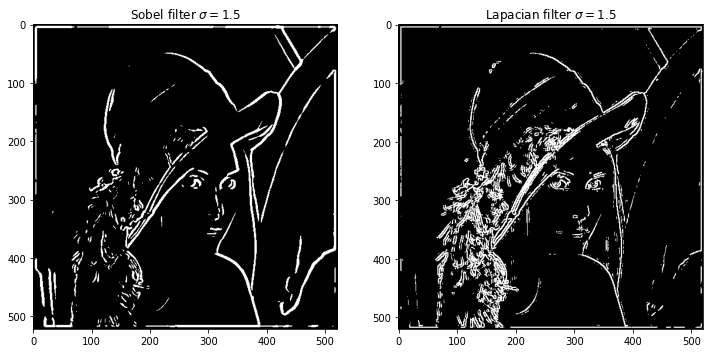

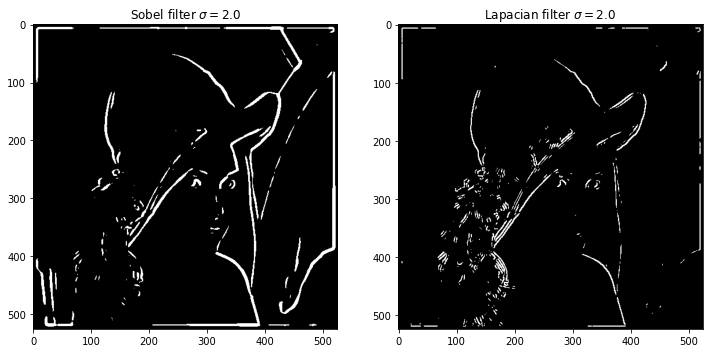

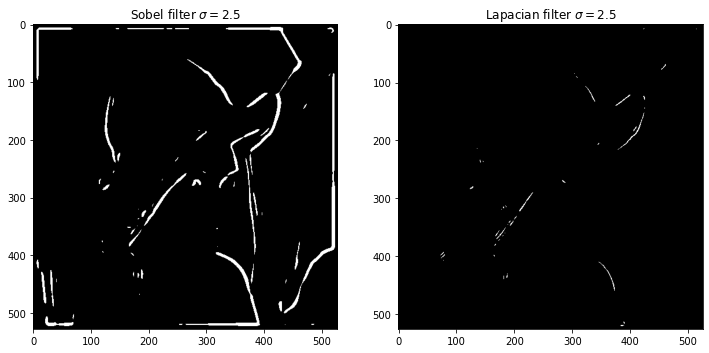

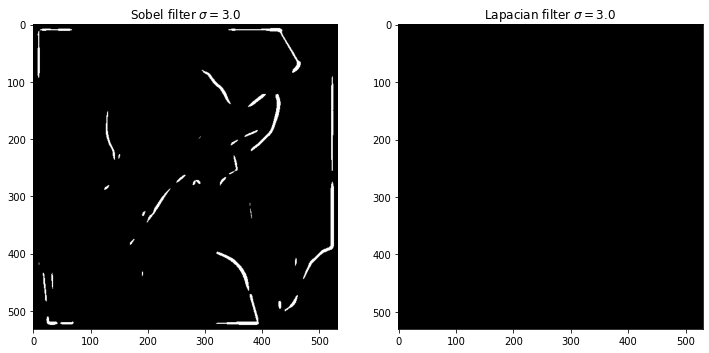

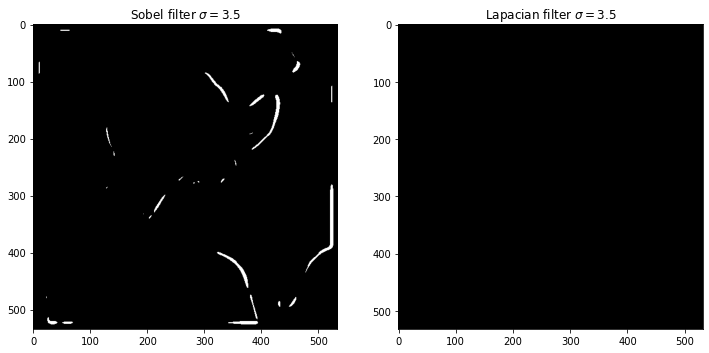

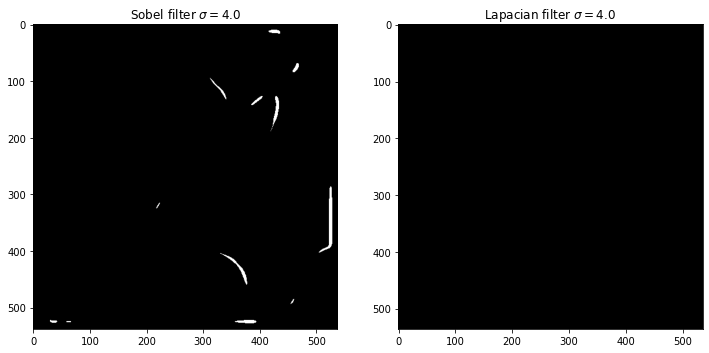

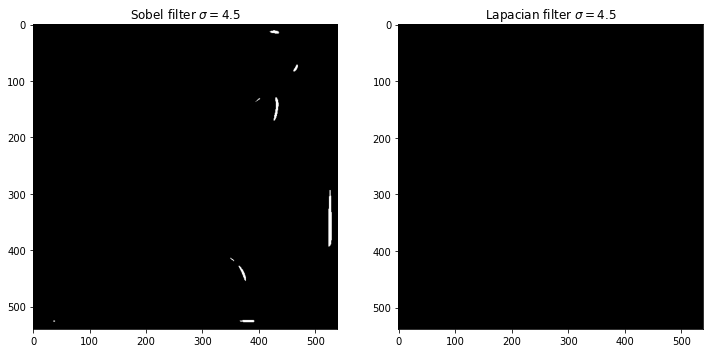

In [8]:
for i in range(1,10):
    Gauss2 = convolve2d(img,gaussianKernel(i*0.5))
    Sob = SobelDetector(Gauss2,120)
    Lap = LaplacianDetector(Gauss2,10)

    niceDisplay14([Sob,Lap],[f"Sobel filter $\sigma = {i*0.5}$",f"Lapacian filter $\sigma = {i*0.5}$"])

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

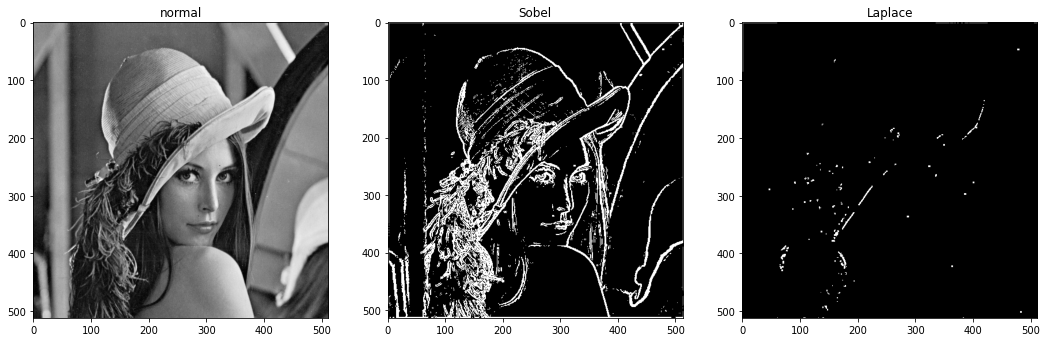

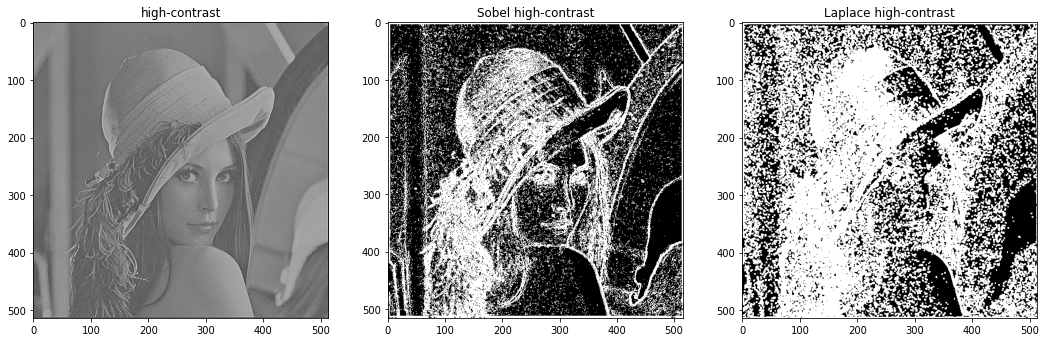

In [170]:
# The following kernel was drawn from the lecture's slides.
contrast = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
contrastLena = convolve2d(img,contrast)

sobelLena = SobelDetector(np.array(img),100)
laplaceLena = LaplacianDetector(np.array(img),255)

sobelLenaHigh = SobelDetector(contrastLena,100)
laplaceLenaHigh = LaplacianDetector(contrastLena,255)
niceDisplay14([np.array(img),sobelLena,laplaceLena], ["normal", "Sobel","Laplace"])
niceDisplay14([contrastLena, sobelLenaHigh,laplaceLenaHigh], ["high-contrast", "Sobel high-contrast","Laplace high-contrast"])

passing the picture under a high contrast kernel make the high frequency stand out more, that why the sbel and laplacian are picking up more information.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [173]:
img = np.array(img)

img = convolve2d(img,gaussianKernel(2))

soble = []
sobleText = []

lap = []
lapText = []
for i in range(0,8):
        soble.append(SobelDetector(subSample(img,2**i),200))
        lap.append(LaplacianDetector(subSample(img,2**i),10))
        
        lapText.append(f"Laplacian subsample {2**i}")
        sobleText.append(f"Sobel subsample {2**i}")

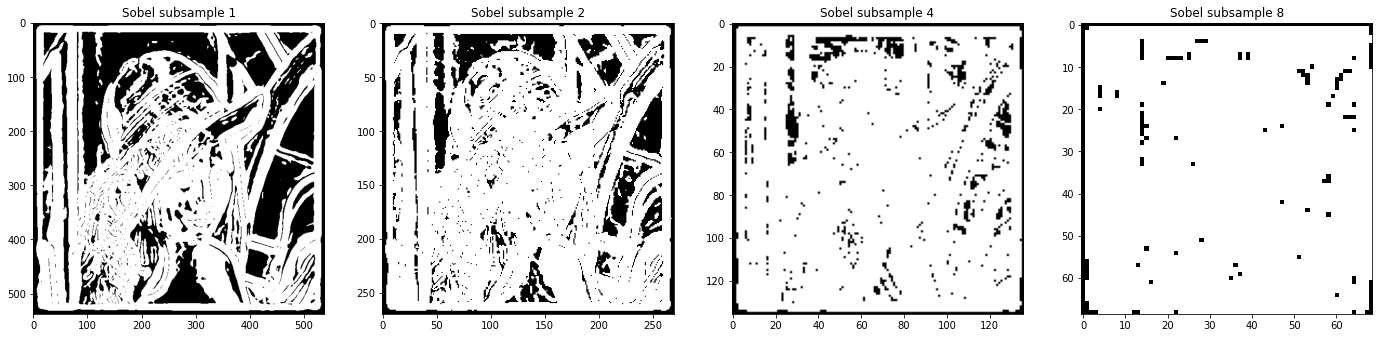

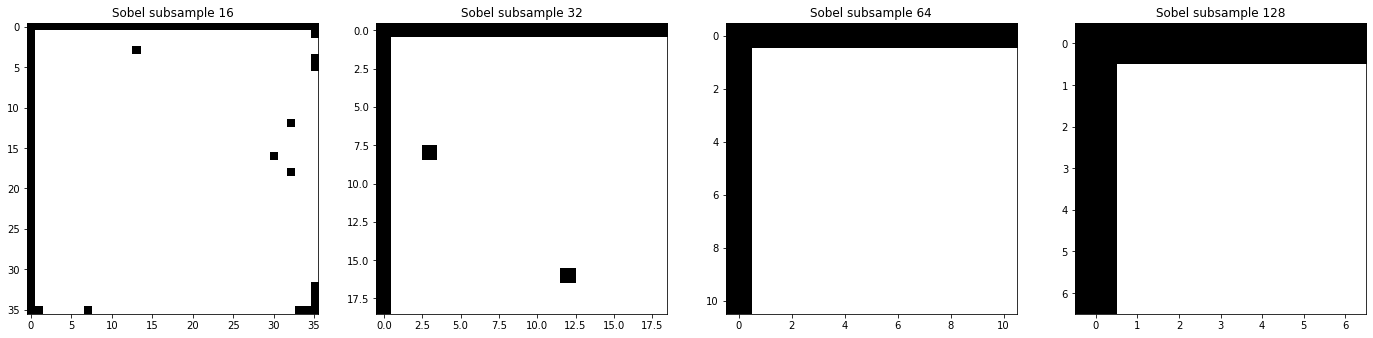

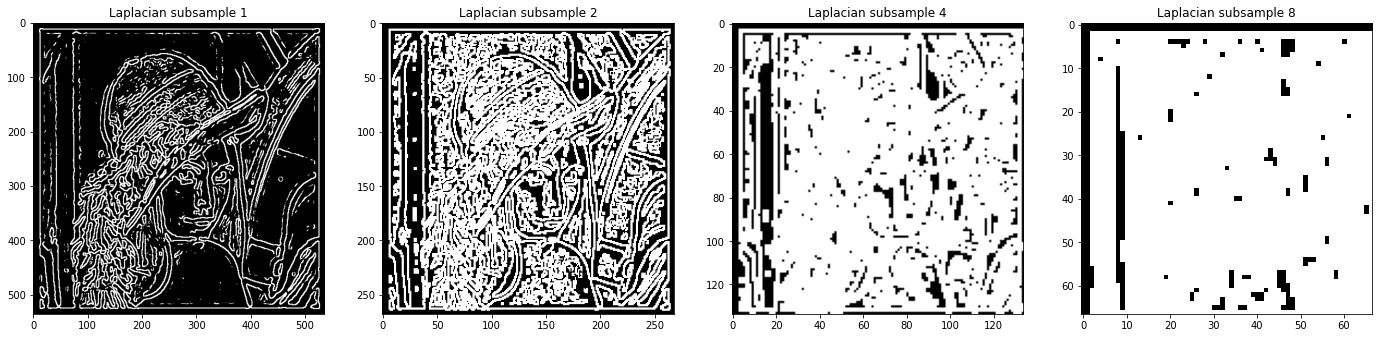

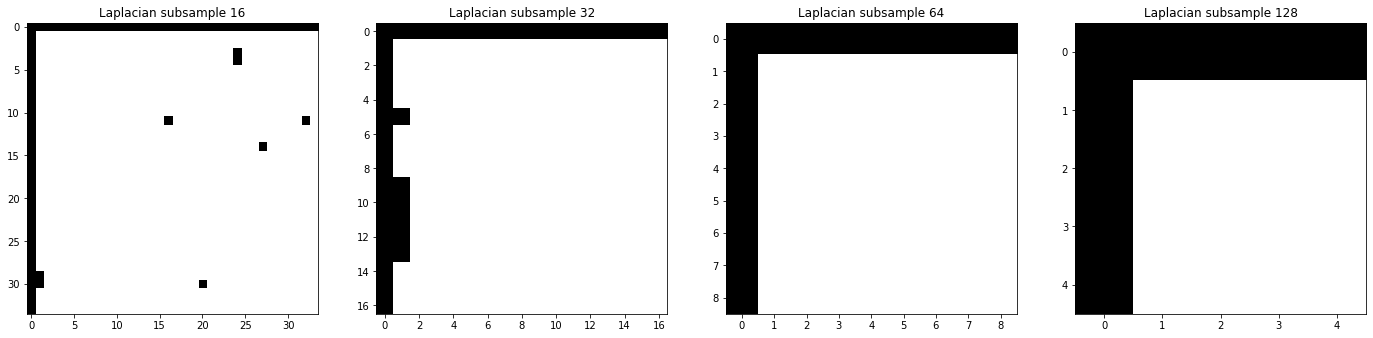

In [174]:
niceDisplay14(soble[0:4], sobleText[0:4])
niceDisplay14(soble[4:],  sobleText[4:])

niceDisplay14(lap[0:4], lapText[0:4])
niceDisplay14(lap[4:],  lapText[4:])

we can see that the laplacian filter is more robust than the sobel one. but still subsampling in the image put a lot of the data away at each subsampling.